# Table of Contents
 <p><div class="lev1 toc-item"><a href="#配置" data-toc-modified-id="配置-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>配置</a></div><div class="lev1 toc-item"><a href="#读取和处理数据" data-toc-modified-id="读取和处理数据-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>读取和处理数据</a></div><div class="lev1 toc-item"><a href="#估计协方差矩阵" data-toc-modified-id="估计协方差矩阵-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>估计协方差矩阵</a></div><div class="lev1 toc-item"><a href="#用协方差矩阵聚类" data-toc-modified-id="用协方差矩阵聚类-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>用协方差矩阵聚类</a></div><div class="lev1 toc-item"><a href="#降维" data-toc-modified-id="降维-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>降维</a></div><div class="lev1 toc-item"><a href="#建立图模型" data-toc-modified-id="建立图模型-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>建立图模型</a></div><div class="lev1 toc-item"><a href="#由曲线图看相关性" data-toc-modified-id="由曲线图看相关性-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>由曲线图看相关性</a></div>

# 配置

In [9]:
import tushare as ts
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})  # for chinese display
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False  # for minus display

# ts.get_industry_classified()

# 读取和处理数据

把今年所有交易日的涨跌百分比存入字典pc_dict：

In [10]:
sz50 = ts.get_sz50s()
pc_dict = {}
for code in sz50.code:
    pc_dict[code] = ts.get_hist_data(code, start='2017-01-01',end='2017-02-21').p_change

把字典转成DataFrame，并去掉其中有NaN的行：

In [11]:
df = pd.DataFrame(pc_dict).T.dropna()
df.head()

,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-16,...,2017-02-08,2017-02-09,2017-02-10,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-20,2017-02-21
600000,0.56,0.18,-0.18,-0.74,0.12,-0.06,-0.18,-0.25,0.93,1.78,...,0.00,0.30,0.36,0.42,-0.59,0.54,-0.36,-0.83,1.62,-0.18
600016,0.33,0.00,-0.33,-0.77,0.11,0.11,-0.44,0.11,0.89,1.32,...,-0.22,0.00,-0.11,0.33,-0.44,0.55,-0.33,-0.99,1.22,-0.11
600028,1.85,1.09,3.23,2.09,-0.17,0.68,-2.37,1.22,1.03,1.19,...,-0.34,-0.68,1.03,0.00,-0.51,0.17,-0.68,-0.34,1.55,0.17
600029,0.14,1.00,0.84,-0.14,0.42,7.38,-4.54,-1.50,0.00,0.41,...,0.56,0.28,1.24,0.54,-0.14,0.95,1.61,-1.58,3.09,0.65
600030,0.81,0.18,-0.43,-0.87,0.38,0.25,-0.06,0.31,0.37,0.93,...,1.35,-0.06,0.97,0.12,-0.30,-0.48,0.97,-0.30,1.26,0.18


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, 600000 to 601998
Data columns (total 31 columns):
2017-01-03    47 non-null float64
2017-01-04    47 non-null float64
2017-01-05    47 non-null float64
2017-01-06    47 non-null float64
2017-01-09    47 non-null float64
2017-01-10    47 non-null float64
2017-01-11    47 non-null float64
2017-01-12    47 non-null float64
2017-01-13    47 non-null float64
2017-01-16    47 non-null float64
2017-01-17    47 non-null float64
2017-01-18    47 non-null float64
2017-01-19    47 non-null float64
2017-01-20    47 non-null float64
2017-01-23    47 non-null float64
2017-01-24    47 non-null float64
2017-01-25    47 non-null float64
2017-01-26    47 non-null float64
2017-02-03    47 non-null float64
2017-02-06    47 non-null float64
2017-02-07    47 non-null float64
2017-02-08    47 non-null float64
2017-02-09    47 non-null float64
2017-02-10    47 non-null float64
2017-02-13    47 non-null float64
2017-02-14    47 non-null float64
2017-02-1

这里一共有47个股票（从上证50里去掉了3个带NaN的），每个股票有31个交易日的数据作为特征。

# 估计协方差矩阵

用GraphLasso模型，估计协方差矩阵。

该模型假定逆协方差矩阵是稀疏的，即概率图模型中条件独立的关系很少（后面解释），适合在小样本上估计协方差矩阵。

In [13]:
edge_model = covariance.GraphLassoCV()
edge_model.fit(df.T)

GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

# 用协方差矩阵聚类

聚类方法是affinity propagation

该方法用变量之间的相似度矩阵对变量做聚类，而协方差可以看成一种变量之间的相似度度量。

In [14]:
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('%i: %s' % ((i + 1), ', '.join(sz50.name[sz50.code.isin(df[labels == i].index)])))

1: 中国石化, 南方航空, 中信证券, 保利地产, 中国联通, 同方股份, 国金证券, 北方稀土, 康美药业, 山东黄金, 东方明珠, 伊利股份, 中航动力, 招商证券, 大秦铁路, 中国神华, 东兴证券, 国泰君安, 兴业证券, 中国建筑, 华泰证券, 中国中车, 光大证券, 中国石油, 中国核电, 中国重工
2: 贵州茅台, 中国铁建, 中国中铁, 中国交建
3: 浦发银行, 民生银行, 招商银行, 上汽集团, 海通证券, 兴业银行, 北京银行, 农业银行, 中国平安, 交通银行, 新华保险, 工商银行, 中国太保, 中国人寿, 光大银行, 中国银行, 中信银行


得到如上3个聚类（但聚类内部仍存在不同的关联关系，后面会从图模型角度分析）。

GraphLasso除了得到协方差矩阵之外，还得到了协方差矩阵的逆矩阵，也就是所谓的精度矩阵（precision matrix）。

精度矩阵表示概率图模型中，两变量之间条件独立关系的强弱（后面会结合图模型来解释），因此可以通过该矩阵建立图模型，更直观地显示变量（即各股票）之间的关系。

# 降维

现在每个变量都是高维的，必须降维到2D之后才能把图模型可视化出来，这里用LLE方法降维（试了T-SNE，效果不好）：

In [15]:
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(df).T

In [16]:
#node_position_model = manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
#embedding = node_position_model.fit_transform(np.nan_to_num(np.reciprocal(np.abs(edge_model.precision_)))).T

# 建立图模型

点的大小表示股票本身的方差大小，越大说明该股票价格波动越剧烈；点的颜色表示所在聚类。

线越粗和颜色越深，表示线两端连接的节点（股价日内变化）相关性越强。

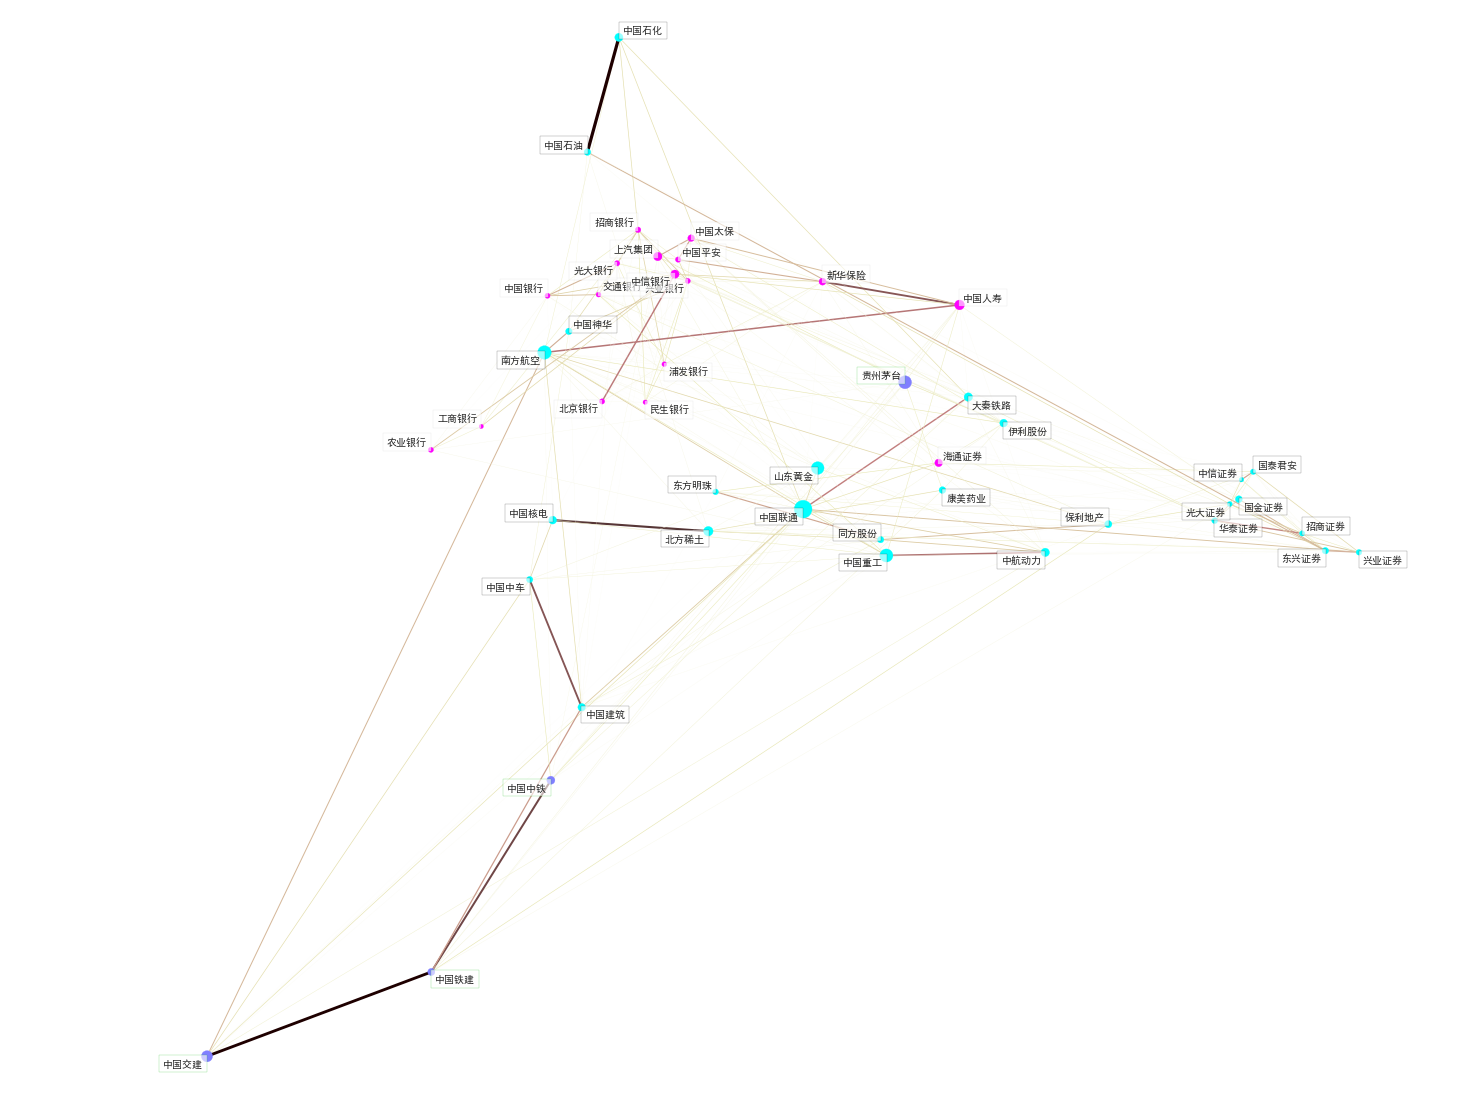

In [17]:
plt.figure(1, facecolor='w', figsize=(20, 15))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels, cmap=plt.cm.cool)

start_idx, end_idx = np.where(non_zero)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.pink_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(5 * values)
ax.add_collection(lc)

for index, (name, label, (x, y)) in enumerate(
        zip([sz50[sz50.code==code].name.values[0] for code in df.index], labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()

这里的相关性是条件相关

可参考：

https://en.wikipedia.org/wiki/Conditional_dependence

https://en.wikipedia.org/wiki/Conditional_independence

如上图所示，左上角的中国石化和中国石油之间条件相关性很强，但二者和其他节点之间几乎不存在条件相关，其内在含义是：对中国石化而言，只要知道了中国石油的股价日内变化就可以，在知道中国石油的情况下，其他股票知不知道关系都不大。当然，也有可能很多因素是这里没考虑到的，比如除这些股票之外的其他股票，以及除股价日内变化之外的其他特征。但就这里考虑到的图上所有股票的股价日内变化而言，对中国石化来说，知道中国石油就够了。用公式来描述，就是 p(中国石化 | 中国石油, 其他) 约等于 p(中国石化 | 中国石油)，同时 p(中国石化 | 中国石油, 其他) 远大于（或远小于） p(中国石化 | 其他)（正相关是远大于，负相关是远小于）。

而左下角的中国铁建，则是和中国交建、中国中铁条件相关。若我们想推断中国铁建的股价，必须知道中国中铁和中国交建的股价，只知道其中之一仍是不足的。以公式来描述，即为 p(中国铁建 | 中国交建, 中国中铁, 其他) 约等于 p(中国铁建 | 中国交建, 中国中铁)，同时 p(中国铁建 | 中国交建, 中国中铁) 大于 p(中国铁建 | 中国交建)，p(中国铁建 | 中国交建, 中国中铁) 也大于 p(中国铁建 | 中国中铁)，但 p(中国铁建 | 中国交建) 和 p(中国铁建 | 中国交建, 中国中铁) 又都远大于 p(中国铁建 | 其他)。

在今后的实践中，我们可以在美元、黄金等各种交易品上做这样的图模型分析，也可以对时间序列做一些特征变换（比如差分、平移）之后进行分析（一般来说，如果特征是股价，则一阶差分表示股价变化的速度，二阶差分表示股价变化的加速度，即速度的速度或变化的变化，那么如果原始特征是股价的时间序列，则差分后有相关性可能说明某股票股价和另一股票涨跌速度相关，或两股票涨跌速度相关；而平移后有相关性，则可能说明某股票的当天股价，与另一股票昨天或前天的股价相关）。

# 由曲线图看相关性

In [18]:
def get_stock_by_name(name):
    return df.loc[sz50[sz50.name==name].code.values[0]]

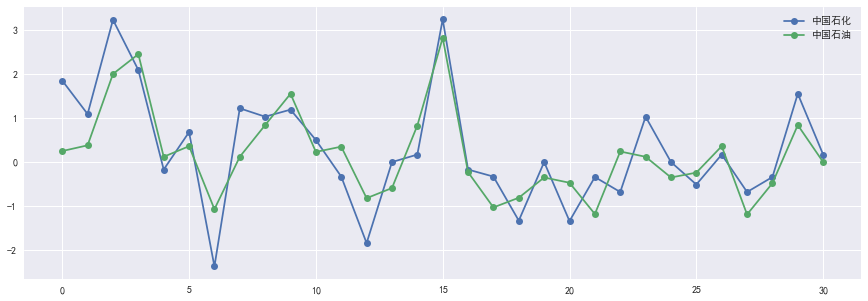

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
name = '中国石化'
stock = get_stock_by_name(name)
plt.plot(range(len(stock)), stock.values, 'o-', label=name)
name = '中国石油'
stock = get_stock_by_name(name)
plt.plot(range(len(stock)), stock.values, 'o-', label=name)
plt.legend();

二者同涨同跌的趋势很明显，但也有某几天偏差相对较大，这时也许存在投资机会。

比如，如果中国石化某一天涨得很猛，但中国石油这天涨得没那么猛，那下一个交易日，中国石化也许会收敛一些，中国石油可能会更猛一点，总之是让二者的涨跌幅度更为接近。

而且由前面的条件相关性分析可知，其他股票的日内变化，无法解释这两个股票日内变化间的偏差。

可以设定一个偏差阈值，用一些大偏差样本作为训练数据，去预测下个交易日的回归趋势。

另外一个很直接的结论是：如果某日中国石化涨了很多，但中国石油还没涨，那么因为二者日内股价变化具有很强的相关性，则之后要么中国石化跌回来，要么中国石油涨上去。具体如何变化，可能需要有每小时股价数据才能判断。但重点在于，二者虽然日内股价变化有强相关，但仍然不可能完全同时涨同时跌，一定有一个先后顺序，这里存在的时间差就是投资机会。

下面是图模型中其他几个较强相关性的曲线图：

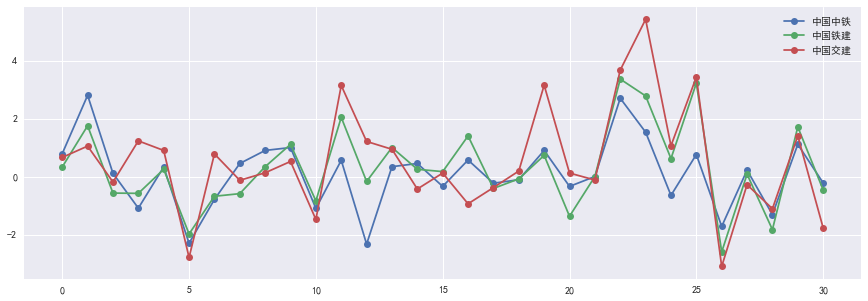

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
name = '中国中铁'
stock = get_stock_by_name(name)
plt.plot(range(len(stock)), stock.values, 'o-', label=name)
name = '中国铁建'
stock = get_stock_by_name(name)
plt.plot(range(len(stock)), stock.values, 'o-', label=name)
name = '中国交建'
stock = get_stock_by_name(name)
plt.plot(range(len(stock)), stock.values, 'o-', label=name)
plt.legend();

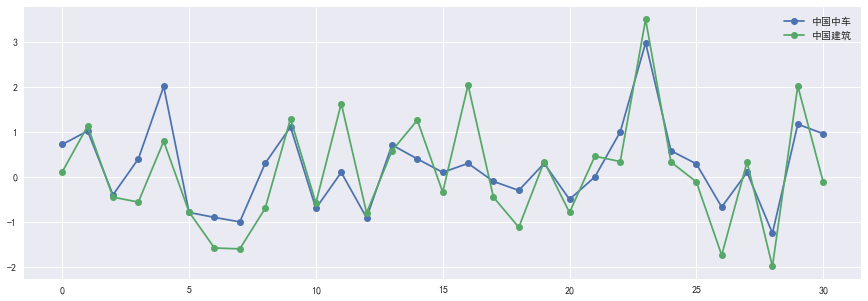

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
name = '中国中车'
stock = get_stock_by_name(name)
plt.plot(range(len(stock)), stock.values, 'o-', label=name)
name = '中国建筑'
stock = get_stock_by_name(name)
plt.plot(range(len(stock)), stock.values, 'o-', label=name)
plt.legend();

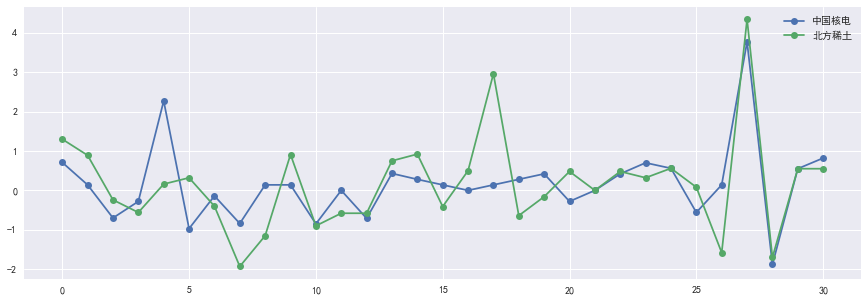

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
name = '中国核电'
stock = get_stock_by_name(name)
plt.plot(range(len(stock)), stock.values, 'o-', label=name)
name = '北方稀土'
stock = get_stock_by_name(name)
plt.plot(range(len(stock)), stock.values, 'o-', label=name)
plt.legend();

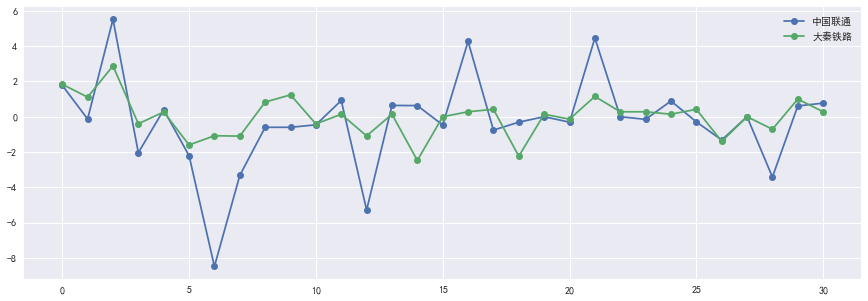

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
name = '中国联通'
stock = get_stock_by_name(name)
plt.plot(range(len(stock)), stock.values, 'o-', label=name)
name = '大秦铁路'
stock = get_stock_by_name(name)
plt.plot(range(len(stock)), stock.values, 'o-', label=name)
plt.legend();

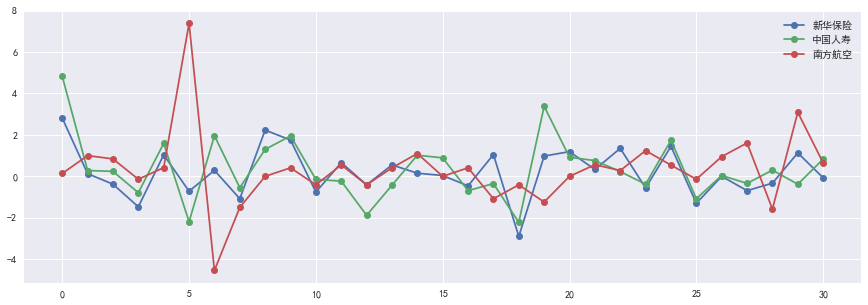

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
name = '新华保险'
stock = get_stock_by_name(name)
plt.plot(range(len(stock)), stock.values, 'o-', label=name)
name = '中国人寿'
stock = get_stock_by_name(name)
plt.plot(range(len(stock)), stock.values, 'o-', label=name)
name = '南方航空'
stock = get_stock_by_name(name)
plt.plot(range(len(stock)), stock.values, 'o-', label=name)
plt.legend();